# Data Analysis

In [ ]:
import pandas as pd


# Load dataset
data = pd.read_csv("sportoclanky.csv")

# Display dataset
data.head()

,category,rss_title,rss_perex
0,biatlon,"Krčmář dojel v hromadném závodě devátý, díky s...",Závod s hromadným startem v německém Oberhofu ...
1,biatlon,Česká vlajka byla v Pokljuce vidět i ve štafet...,Galerie
2,biatlon,Živě: Stíhací závod biatlonistek v Ruhpoldingu,"15. 1., 14:45"
3,fotbal,Bakoš dostal herdu do nosu a v zápase plném ka...,Slovenský útočník Marek Bakoš zařídil Plzni gó...
4,fotbal,"My moc chtěli a Plzeň moc nechtěla, zní z Ďolí...",Český fotbal hledá viníka skandálu odloženého ...


In [ ]:
# Show dataset shape
data.shape

(111218, 3)

In [ ]:
# Show dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111218 entries, 0 to 111217
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   category   111218 non-null  object
 1   rss_title  111218 non-null  object
 2   rss_perex  111218 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


The data does not contain any missing values, it will simplify the data preprocessing

In [ ]:
# Check unique categories and their distribution
data["category"].value_counts()

,count
category,
fotbal,45891
hokej,28775
tenis,11437
formule1,5733
moto,4813
atletika,2552
basketbal,2492
cyklistika,2048
biatlon,1526


In [ ]:
num_labels = len(data["category"].value_counts())
num_labels

24

There is a significant class imbalance (football: 45891 vs hockeyball: 6)

In [ ]:
# Check sample text lengths
data[["rss_title", "rss_perex"]].applymap(lambda x: len(str(x))).describe()

<ipython-input-6-03b83dc9b56b>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[["rss_title", "rss_perex"]].applymap(lambda x: len(str(x))).describe()


,rss_title,rss_perex
count,111218.000000,111218.000000
mean,64.724730,305.470041
std,16.613132,157.007392
min,3.000000,3.000000
25%,59.000000,207.000000
50%,66.000000,304.000000
75%,73.000000,399.000000
max,188.000000,2666.000000


There is a large class imbalance in the data. To solve this problem, we will use stratified sampling during training when splitting into train and test. Also, when evaluating the model, we should focus primarily on such metrics as f1, precision, and recall, since they are stable with class imbalance.
The lengths of titles and articles appear reasonable, but the shortest length of 3 characters is concerning and is most likely noise, so we have to drop them.

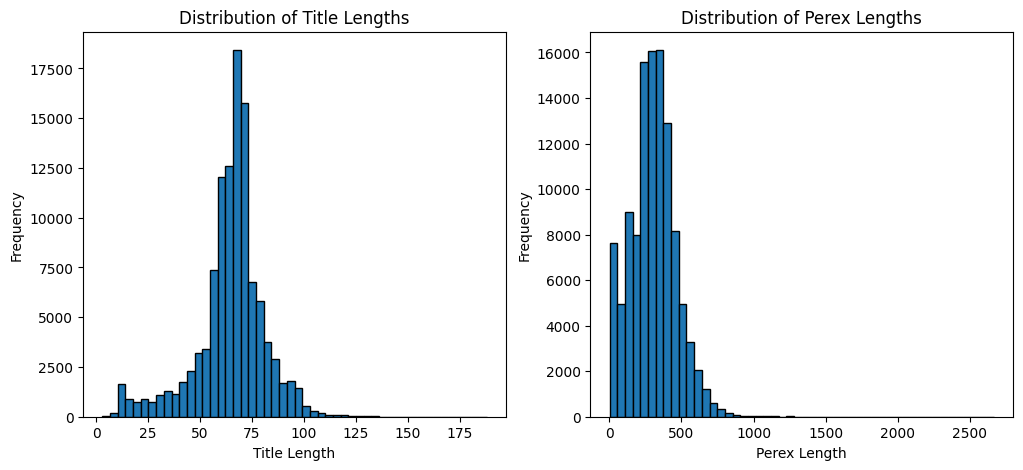

In [ ]:
import matplotlib.pyplot as plt


# Plot histogram for title length
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data["rss_title"].apply(len), bins=50, edgecolor="black")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.title("Distribution of Title Lengths")

# Plot histogram for perex length
plt.subplot(1, 2, 2)
plt.hist(data["rss_perex"].apply(len), bins=50, edgecolor="black")
plt.xlabel("Perex Length")
plt.ylabel("Frequency")
plt.title("Distribution of Perex Lengths")

plt.show()

In [ ]:
# Create a copy of the original dataset
data_copy = data.copy()

# Remove noise
data_copy = data_copy[(data_copy["rss_title"].str.len() >= 10) & (data_copy["rss_perex"].str.len() >= 20)]

In [ ]:
# New dataset size
len(data_copy)

107596

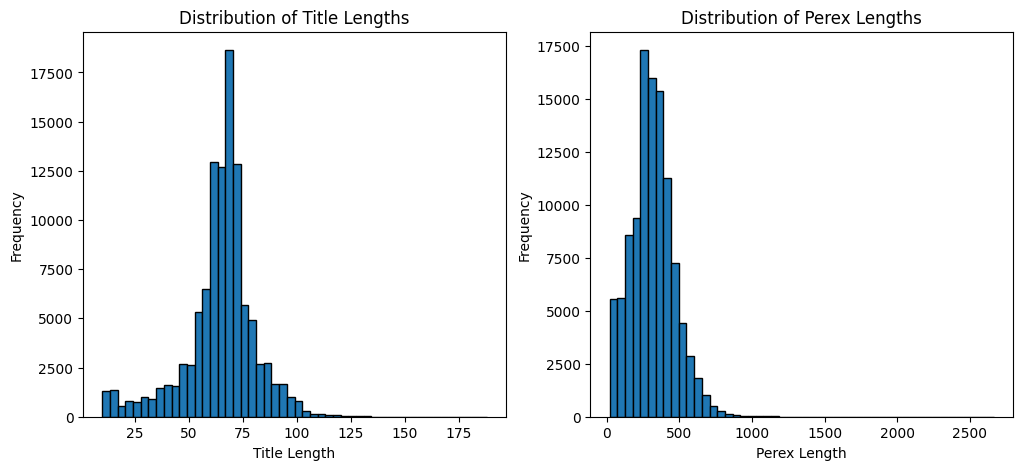

In [ ]:
# Plot histogram for title length
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data_copy["rss_title"].apply(len), bins=50, edgecolor="black")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.title("Distribution of Title Lengths")

# Plot histogram for perex length
plt.subplot(1, 2, 2)
plt.hist(data_copy["rss_perex"].apply(len), bins=50, edgecolor="black")
plt.xlabel("Perex Length")
plt.ylabel("Frequency")
plt.title("Distribution of Perex Lengths")

plt.show()

Titles have a normal distribution, with no extremely short values.
Descriptions also look cleaner, with no very small values.

# Data preprocessing
For successful neural network training, a tokenizer is necessary since split() is ineffective for such large text volumes.
We will use TreebankWordTokenizer because it is more accurate compared to other NLTK tokenizers, although slower.
However, since our dataset is not very large, this slowdown is not critical for our task.

In [ ]:
import re
from nltk.tokenize import TreebankWordTokenizer


# Initialize the tokenizer
tokenizer = TreebankWordTokenizer()

def clean_text(text):
    """
    Preprocess the input text:
    - Convert to lowercase
    - Remove special characters and numbers
    - Tokenize using TreebankWordTokenizer
    """
    text = str(text).lower()               # Ensure text is a string and convert to lowercase
    text = re.sub(r"\d+", "", text)        # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)    # Remove punctuation
    tokens = tokenizer.tokenize(text)      # Tokenize text
    return " ".join(tokens)

data_copy["clean_title"] = data_copy["rss_title"].apply(clean_text)
data_copy["clean_perex"] = data_copy["rss_perex"].apply(clean_text)

In [ ]:
# Check the first lines of processed data
display(data_copy[["clean_title","clean_perex"]].head())

,clean_title,clean_perex
0,krčmář dojel v hromadném závodě devátý díky sk...,závod s hromadným startem v německém oberhofu ...
3,bakoš dostal herdu do nosu a v zápase plném ka...,slovenský útočník marek bakoš zařídil plzni gó...
4,my moc chtěli a plzeň moc nechtěla zní z ďolíč...,český fotbal hledá viníka skandálu odloženého ...
5,novou sezonu otevře zápas brna s nováčkem ostr...,podívejte se na program prvního kola nové fotb...
6,s radou už sparta moc nepočítá kotalík hledá z...,pokud se ještě fotbalisté sparty nevyhrabou na...


In [ ]:
data_copy.loc[42, "clean_title"]

'v západní konferenci khl jsou známi čtvrtfinalisté dál jde i nakládalova jaroslavl'

In [ ]:
data_copy.loc[42, "clean_perex"]

'osmifinálové série v západní konferenci khl dramatické nebyly na hladké postupy petrohradu a moskevského cska navázaly jaroslavl a dynamo moskva'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Extract the label from the processed features
X_texts = data_copy["clean_title"] + " " + data_copy["clean_perex"]
y_labels = data_copy["category"]

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_texts, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Model training (Support Vector Machine)

In [ ]:
# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000) # Limit the number of features to reduce dimensionality and computational costs
X_train_data = vectorizer.fit_transform(X_train)
X_test_data = vectorizer.transform(X_test)

In [ ]:
# Training SVM
svm_model = SVC(kernel="linear", C=1.0)  # The linear kernel works best with text
svm_model.fit(X_train_data, y_train)

SVC(kernel='linear')

In [ ]:
# Predictions on test data
y_pred = svm_model.predict(X_test_data)

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      atletika       0.92      0.91      0.91       504
      baseball       0.94      0.59      0.72        29
     basketbal       0.99      0.94      0.96       498
       biatlon       0.99      0.96      0.97       291
           box       1.00      0.47      0.64        30
    cyklistika       0.95      0.94      0.94       407
       dostihy       1.00      0.64      0.78        11
       florbal       1.00      0.75      0.86       105
      formule1       0.95      0.97      0.96      1147
        fotbal       0.97      0.99      0.98      8859
        futsal       1.00      0.38      0.55         8
          golf       0.99      0.87      0.92        90
        hazena       0.98      0.76      0.85       132
         hokej       0.97      0.98      0.98      5531
      hokejbal       1.00      1.00      1.00         1
 krasobrusleni       1.00      0.73      0.85        15
lyze_snowboard       0.95      0.85      0.90  

Weighted avg f1-score of 0.97 is an excellent result. The most frequent categories are classified almost perfectly,
but there are issues with rare categories due to the small amount of data. There is also a problem with collective sports,
such as Olympijske_hry, since these categories include multiple types of sports.

For curiosity, let's try enabling class balancing to mitigate the imbalance.

In [ ]:
svm_model = SVC(kernel="linear", C=1.0, random_state=42, class_weight="balanced")
svm_model.fit(X_train_data, y_train)

y_pred = svm_model.predict(X_test_data)

In [ ]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      atletika       0.90      0.93      0.91       504
      baseball       0.92      0.83      0.87        29
     basketbal       0.98      0.95      0.97       498
       biatlon       0.97      0.97      0.97       291
           box       0.92      0.73      0.81        30
    cyklistika       0.93      0.94      0.94       407
       dostihy       1.00      0.91      0.95        11
       florbal       0.93      0.87      0.90       105
      formule1       0.94      0.98      0.96      1147
        fotbal       0.98      0.99      0.98      8859
        futsal       1.00      0.62      0.77         8
          golf       0.98      0.91      0.94        90
        hazena       0.88      0.81      0.85       132
         hokej       0.98      0.98      0.98      5531
      hokejbal       1.00      1.00      1.00         1
 krasobrusleni       1.00      0.93      0.97        15
lyze_snowboard       0.91      0.89      0.90  

Balancing slightly improved the situation with rare classes.
Macro avg f1-score (0.85 -> 0.90)
Macro avg recall (0.79 -> 0.86)


# Neural network with a transformer architecture

Now, we will try using neural networks with a transformer architecture.  
For this, we will use the Czech BERT model: Czert-B-base-cased.

We have chosen Czert-B-base-cased because:
- Specifically trained for the Czech language – unlike mBERT, which covers a lot of languages, Czert-B-base-cased is fine-tuned for Czech texts.
- Expected to achieve higher accuracy – especially for complex and less frequent categories.


In [ ]:
# Use a pipeline
from transformers import pipeline


pipe = pipeline("fill-mask", model="UWB-AIR/Czert-B-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/do

In [ ]:
# Test it
result = pipe("Mám [MASK] datovou vědu.")
print(result)

[{'score': 0.5975901484489441, 'token': 3411, 'token_str': 'rád', 'sequence': 'Mám rád datovou vědu.'}, {'score': 0.13194940984249115, 'token': 8556, 'token_str': 'ráda', 'sequence': 'Mám ráda datovou vědu.'}, {'score': 0.023623047396540642, 'token': 3, 'token_str': '[SEP]', 'sequence': 'Mám datovou vědu.'}, {'score': 0.021025124937295914, 'token': 3488, 'token_str': 'vlastní', 'sequence': 'Mám vlastní datovou vědu.'}, {'score': 0.01782373897731304, 'token': 26542, 'token_str': 'nejraději', 'sequence': 'Mám nejraději datovou vědu.'}]


Since the model is functioning correctly, we can proceed with using it

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch


# Load the tokenizer and pre-trained model
model_name = "UWB-AIR/Czert-B-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UWB-AIR/Czert-B-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze all layers except the classification head
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder


# Encode category labels
label_encoder = LabelEncoder()
data_copy["category_encoded"] = label_encoder.fit_transform(data_copy["category"])

# Apply tokenization to the dataset
data_copy["tokenized"] = data_copy["clean_title"].apply(
    lambda x: tokenizer(x, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
)

# Extract input_ids and attention_mask for Pytorch dataset
input_ids = [item["input_ids"].squeeze(0) for item in data_copy["tokenized"]]
attention_mask = [item["attention_mask"].squeeze(0) for item in data_copy["tokenized"]]
labels = data_copy["category_encoded"].values

In [ ]:
from torch.utils.data import Dataset, DataLoader


train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Create dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": torch.tensor(self.labels[idx])
        }

# Create PyTorch dataset objects
train_dataset = NewsDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = NewsDataset(test_input_ids, test_attention_mask, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
from torch.utils.data import Dataset, DataLoader


model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training parameters
num_epochs = 5

### Optimizing Training Speed
Training currently takes too long (40 minutes per epoch). To speed up the process, we will apply several optimizations:

- Increase batch size – This will reduce the number of iterations per epoch while maintaining stable training dynamics.
- Compile the model – Using `torch.compile()`, we can optimize computations, fuse operations, and improve execution efficiency.
- Enable mixed precision training – This reduces memory usage by using 16-bit floating-point numbers where possible, speeding up computations without significant accuracy loss.

These changes will help accelerate the training process while maintaining model performance.


In [ ]:
model = torch.compile(model)

In [ ]:
from torch.amp import autocast, GradScaler
from tqdm import tqdm


scaler = GradScaler("cuda")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

100%|██████████| 5380/5380 [11:06<00:00,  8.07it/s]


Epoch 1/10, Loss: 1.7784


100%|██████████| 5380/5380 [10:35<00:00,  8.46it/s]


Epoch 2/10, Loss: 1.5912


100%|██████████| 5380/5380 [10:41<00:00,  8.39it/s]


Epoch 3/10, Loss: 1.4988


100%|██████████| 5380/5380 [10:38<00:00,  8.43it/s]


Epoch 4/10, Loss: 1.4353


100%|██████████| 5380/5380 [10:42<00:00,  8.37it/s]


Epoch 5/10, Loss: 1.3887


100%|██████████| 5380/5380 [10:37<00:00,  8.44it/s]


Epoch 6/10, Loss: 1.3535


  1%|          | 47/5380 [00:05<10:41,  8.31it/s]


KeyboardInterrupt: 

In [ ]:
# from tqdm import tqdm


# # Training
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_loader):
#         optimizer.zero_grad()

#         # Move batch to device
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Forward pass
#         outputs = model(input_ids, attention_mask=attention_mask)
#         loss = loss_fn(outputs.logits, labels)

#         # Backward pass
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

100%|██████████| 10760/10760 [42:34<00:00,  4.21it/s]


Epoch 1/10, Loss: 1.5390


100%|██████████| 10760/10760 [41:20<00:00,  4.34it/s]


Epoch 2/10, Loss: 1.4392


  0%|          | 10/10760 [00:02<45:01,  3.98it/s]


KeyboardInterrupt: 

As we can see, the training speed has increased. Additionally, we notice that 5 epochs are sufficient since the loss does not decrease significantly beyond this point.

In [ ]:
# Evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.5988


In [ ]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.78      0.01      0.03       519
           1       0.00      0.00      0.00        24
           2       1.00      0.00      0.00       474
           3       1.00      0.03      0.06       275
           4       0.00      0.00      0.00        28
           5       0.75      0.01      0.03       418
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00       108
           8       0.64      0.41      0.50      1146
           9       0.61      0.87      0.72      8798
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        89
          12       0.94      0.12      0.22       123
          13       0.57      0.56      0.57      5587
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        13
          16       0.00      0.00      0.00       180
          17       0.57    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


I adapted the Czert-B-base-cased model for multi-class classification of sports news in the Czech language.  
The main goal was to compare two approaches: classical machine learning methods and neural networks based on transformer architecture.

Although the accuracy of the BERT model (Czert-B-base-cased) remained relatively low (**59.88 %** on the test set), it significantly outperformed random guessing (**4.17 %** with 24 classes), indicating that the model learned relevant patterns.  
Only the classification head was trained, while the rest of the model was frozen, which helped speed up the experiment.

Initially, training was very slow — around **40 minutes per epoch**.  
Thanks to techniques such as:

- `torch.compile` (model compilation),
- mixed precision training,
- increasing the batch size,

I managed to **reduce the training time per epoch by half**.  
This made it possible to complete the training and analyze the effect of the number of epochs on the final result.

I also tested class balancing, which led to improved performance for underrepresented categories using the classical approach (TF-IDF + SVM).

---

### Possible improvements for the future:
- Perform a full fine-tuning of the model (unfreeze all layers),
- Increase the number of epochs and tune hyperparameters,
- Try a different architecture (e.g., XLM-R, mBERT),
- Use more training data.